# **Mastering Machine Learning**

*   Nicolas Bedoya Figueroa
*   Rafael Tejón
*   Santiago Arenas
*   Santiago Reyes

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torch.optim import Adam
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

In [6]:
random_seed = 611
torch.manual_seed(random_seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(random_seed)

#### **Utils**

In [7]:
# Function for measuring the accuracy

def get_accuracy(output, y, train_size):
    pred = torch.sigmoid(output) > 0.5  # Thresholding
    correct = pred.eq(y.bool()).sum().item()
    return correct / train_size

In [10]:
# Saving the best model

def save_checkpoint(model_save):
    torch.save(model_save.state_dict(), "best_model.pth")
    

In [11]:
# Loading the best model

def load_checkpoint(model_load):
    checkpoint = torch.load("best_model.pth", map_location=device)
    checkpoint = { k.replace("_orig_mod.", ""): v for k, v in checkpoint.items() }
    model_load.load_state_dict(checkpoint)
    model_load = torch.compile(model_load.to(device), backend="eager")
    model_load.eval()
    return model_load
    

In [12]:
# Loss and accuracy graphing

def loss_accuracy_graph(loss_accuracy_list):
    epochs = len(loss_accuracy_list)
    train_loss = [loss_accuracy_list[i][0] for i in range(epochs)]
    train_accuracy = [loss_accuracy_list[i][1] for i in range(epochs)]
    val_loss = [loss_accuracy_list[i][2] for i in range(epochs)]
    val_accuracy = [loss_accuracy_list[i][3] for i in range(epochs)]

    plt.plot(range(1, epochs + 1), train_loss, 'r-', label = "Training")
    plt.plot(range(1, epochs + 1), val_loss, 'b-', label = "Validation")
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Train and Validation Loss')
    plt.show()

    plt.plot(range(1, epochs + 1), train_accuracy, 'r-', label = "Training")
    plt.plot(range(1, epochs + 1), val_accuracy, 'b-', label = "Validation")
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Train and Validation Accuracy')
    plt.show()
    

In [15]:
# Check GPU availability

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.is_available()

True

#### **roBERTa Fine tunning with a dense classification head**

##### **Utils**

In [15]:
# Training function

def train(train_loader, optimizer, loss_function, model_train):
    loss = 0
    accuracy = 0
    batch_num = 0
    model_train.train()
    for batch in train_loader:
        batch_num += 1
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        y = batch["label"].to(device).float()
        output = model_train(input_ids, attention_mask)
        optimizer.zero_grad()
        batch_loss = loss_function(output, y)
        batch_loss.backward()
        optimizer.step()

        loss += batch_loss.item()
        accuracy += get_accuracy(output, y, len(train_loader.dataset))
    print(f"Train Loss: {round(loss/batch_num, 5)}, Train Accuracy: {round(accuracy, 5)}")

    return loss/batch_num, accuracy

In [16]:
# Validation function

def validate(val_loader, loss_function, model_val):

    loss = 0
    accuracy = 0
    batch_num = 0

    model_val.eval()
    with torch.no_grad():
        for batch in val_loader:
            batch_num += 1
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            y = batch["label"].to(device).float()
            output = model_val(input_ids, attention_mask)
            batch_loss = loss_function(output, y)

            loss += batch_loss.item()
            accuracy += get_accuracy(output, y, len(val_loader.dataset))
    print(f"Validation Loss: {round(loss/batch_num, 5)}, Validation Accuracy: {round(accuracy, 5)}")
    return loss/batch_num, accuracy

In [17]:
# Model evaluation

def evaluate_model(model_load, test_loader):
    model_eval = load_checkpoint(model_load)
    batch = next(iter(test_loader))
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    y = batch["label"].cpu().float().numpy()

    with torch.no_grad():
        y_pred = model_eval(input_ids, attention_mask)
    
    pred = torch.sigmoid(y_pred).cpu().numpy() > 0.5
    
    print(classification_report(y, pred))

    conf_matrix = confusion_matrix(y, pred)

    sns.heatmap(conf_matrix, xticklabels = ["0", "1"], yticklabels = ["0", "1"], annot=True, cmap='Blues', fmt = 'g')
    plt.ylabel("Real")
    plt.xlabel("Predicción")
    plt.show()

In [18]:
# Model evaluation without loading

def evaluate_model_no_load(model_eval, test_loader):
    batch = next(iter(test_loader))
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    y = batch["label"].cpu().float().numpy()
    model_eval.eval()
    with torch.no_grad():
        y_pred = model_eval(input_ids, attention_mask)
    
    pred = torch.sigmoid(y_pred).cpu().numpy() > 0.5
    
    print(classification_report(y, pred))

    conf_matrix = confusion_matrix(y, pred)

    sns.heatmap(conf_matrix, xticklabels = ["0", "1"], yticklabels = ["0", "1"], annot=True, cmap='Blues', fmt = 'g')
    plt.ylabel("Real")
    plt.xlabel("Predicción")
    plt.show()

In [19]:
# Training loop

def training_loop(epochs, train_loader, val_loader, optimizer, loss_function, model_train_loop):
    max_accuracy = 0
    loss_accuracy_list = []

    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        train_loss, train_accuracy = train(train_loader, optimizer, loss_function, model_train_loop)
        current_loss, val_accuracy = validate(val_loader, loss_function, model_train_loop)
        loss_accuracy_list.append((train_loss, train_accuracy, current_loss, val_accuracy))
        if max_accuracy < val_accuracy:
            max_accuracy = val_accuracy
            save_checkpoint(model_train_loop)
            print("Model saved!")
        else:
            print("Model not saved!")
    
    loss_accuracy_graph(loss_accuracy_list)

##### **Implementation**

In [20]:
# Setting the device to use GPU

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.is_available()

True

In [21]:
# Loading the data

data = pd.read_csv('balanced_data.csv')
X = data['tweet'].astype(str).values
y = data['class'].values

In [22]:
# Shuffling the dataset

permutation = np.random.permutation(len(y))
y = y[permutation].reshape(-1, 1)
X = X[permutation].tolist()

In [23]:
# Calculation of the set distribution

test_size = int(y.shape[0] * 0.15)
val_size = int(y.shape[0] * 0.15)
train_size = int(y.shape[0] * 0.7)

In [24]:
# Set definition

X_train = X[:train_size]
y_train = y[:train_size]

X_val = X[train_size:train_size + val_size]
y_val = y[train_size:train_size + val_size]

X_test = X[train_size + val_size : ]
y_test = y[train_size + val_size : ]

In [25]:
# Custom dataset class

class CustomDatasetText(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            self.texts[idx],
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )
        return  {
            "input_ids": encoding["input_ids"].squeeze(0),         # shape: (seq_len)
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "label": torch.tensor(label, dtype=torch.long)
        }

    def __len__(self):
        return len(self.texts)

In [26]:
# Tokenizer and dataset definitions

tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base")
train_set = CustomDatasetText(X_train, y_train, tokenizer, 32)
val_set = CustomDatasetText(X_val, y_val, tokenizer, 32)
test_set = CustomDatasetText(X_test, y_test, tokenizer, 32)

In [27]:
# Creation of the dataloaders

train_loader = DataLoader(train_set, batch_size = 32, shuffle = True)
val_loader = DataLoader(val_set, batch_size = 32, shuffle = True)
test_loader = DataLoader(test_set, batch_size = len(test_set), shuffle = False)

In [28]:
# BERT layer in our custom fine-tuned model

class BERTLayer(nn.Module):
    def __init__(self, model_name):
        super().__init__()
        self.roberta = AutoModel.from_pretrained(model_name)
        for param in self.roberta.parameters():
            param.requires_grad = False

    def activate_grad(self):
        for param in self.roberta.parameters():
            param.requires_grad = True

    def deactivate_grad(self):
        for param in self.roberta.parameters():
            param.requires_grad = False

    def forward(self,input_ids, attention_mask):
        outputs = self.roberta(input_ids= input_ids, attention_mask= attention_mask)
        return outputs.last_hidden_state[:,0,:]

In [29]:
# Model architecture definition

class ClassificationHead(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(768, 256)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p = 0.3)
        self.linear2 = nn.Linear(256, 32)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(p = 0.2)
        self.linear3 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.linear(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.linear3(x)
        
        return x


In [30]:
# Custom model definition

class CustomModel(nn.Module):
    def __init__(self, model_name):
        super().__init__()
        self.bert = BERTLayer(model_name)
        self.head = ClassificationHead()

    def forward(self, input_ids, attention_mask):
        x = self.bert(input_ids, attention_mask)
        x = self.head(x)
        return x

In [31]:
# Model instanciation

model_name = "cardiffnlp/twitter-roberta-base"
model = CustomModel(model_name)
model = torch.compile(model.to(device), backend="eager")
model

OptimizedModule(
  (_orig_mod): CustomModel(
    (bert): BERTLayer(
      (roberta): RobertaModel(
        (embeddings): RobertaEmbeddings(
          (word_embeddings): Embedding(50265, 768, padding_idx=1)
          (position_embeddings): Embedding(514, 768, padding_idx=1)
          (token_type_embeddings): Embedding(1, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): RobertaEncoder(
          (layer): ModuleList(
            (0-11): 12 x RobertaLayer(
              (attention): RobertaAttention(
                (self): RobertaSdpaSelfAttention(
                  (query): Linear(in_features=768, out_features=768, bias=True)
                  (key): Linear(in_features=768, out_features=768, bias=True)
                  (value): Linear(in_features=768, out_features=768, bias=True)
                  (dropout): Dropout(p=0.1, inplace=False)
                )
                (out

In [32]:
# Loss and optimizer definition

loss_function = nn.BCEWithLogitsLoss()
optimizer = Adam(model.parameters())
model = model.to(device)

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      3523
         1.0       0.51      1.00      0.67      3632

    accuracy                           0.51      7155
   macro avg       0.25      0.50      0.34      7155
weighted avg       0.26      0.51      0.34      7155



/home/sis.virtual.uniandes.edu.co/d.escalante/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sis.virtual.uniandes.edu.co/d.escalante/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sis.virtual.uniandes.edu.co/d.escalante/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

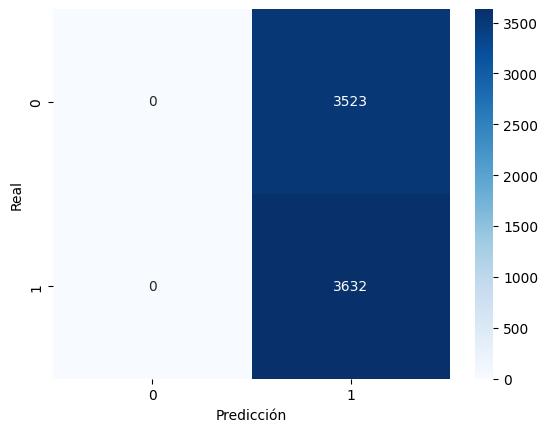

In [33]:
evaluate_model_no_load(model, test_loader)

Epoch 1/150
Train Loss: 0.41102, Train Accuracy: 0.82182
Validation Loss: 0.33935, Validation Accuracy: 0.85225
Model saved!
Epoch 2/150
Train Loss: 0.36752, Train Accuracy: 0.83895
Validation Loss: 0.33807, Validation Accuracy: 0.85491
Model saved!
Epoch 3/150
Train Loss: 0.36043, Train Accuracy: 0.84356
Validation Loss: 0.32414, Validation Accuracy: 0.85784
Model saved!
Epoch 4/150
Train Loss: 0.35687, Train Accuracy: 0.8444
Validation Loss: 0.34337, Validation Accuracy: 0.85421
Model not saved!
Epoch 5/150
Train Loss: 0.35275, Train Accuracy: 0.84614
Validation Loss: 0.32461, Validation Accuracy: 0.86064
Model saved!
Epoch 6/150
Train Loss: 0.35411, Train Accuracy: 0.84512
Validation Loss: 0.32691, Validation Accuracy: 0.86022
Model not saved!
Epoch 7/150
Train Loss: 0.35131, Train Accuracy: 0.8468
Validation Loss: 0.32337, Validation Accuracy: 0.85994
Model not saved!
Epoch 8/150
Train Loss: 0.34878, Train Accuracy: 0.84713
Validation Loss: 0.32337, Validation Accuracy: 0.86092
Mod

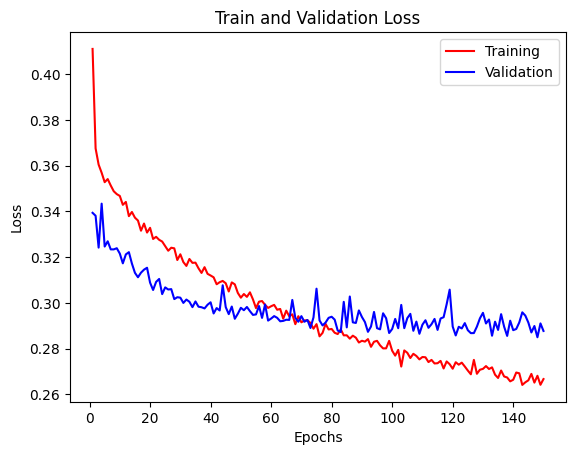

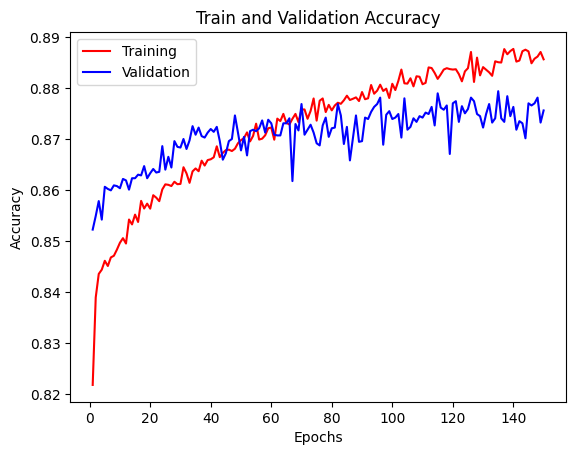

In [33]:
training_loop(150, train_loader, val_loader, optimizer, loss_function, model)

              precision    recall  f1-score   support

         0.0       0.85      0.91      0.88      3462
         1.0       0.91      0.84      0.88      3693

    accuracy                           0.88      7155
   macro avg       0.88      0.88      0.88      7155
weighted avg       0.88      0.88      0.88      7155



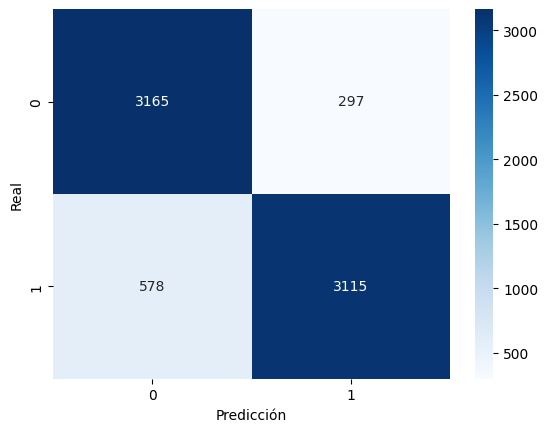

In [34]:
model_load = CustomModel(model_name)
evaluate_model(model_load, test_loader)

In [35]:
# Unfreezing the model's weights

model_load.bert.activate_grad()
optimizer = Adam(model_load.parameters(), lr=.000001)

Epoch 1/100
Train Loss: 0.24712, Train Accuracy: 0.89508
Validation Loss: 0.27791, Validation Accuracy: 0.88426
Model saved!
Epoch 2/100
Train Loss: 0.23142, Train Accuracy: 0.90218
Validation Loss: 0.2777, Validation Accuracy: 0.88314
Model not saved!
Epoch 3/100
Train Loss: 0.222, Train Accuracy: 0.90574
Validation Loss: 0.27488, Validation Accuracy: 0.88482
Model saved!
Epoch 4/100
Train Loss: 0.21605, Train Accuracy: 0.9091
Validation Loss: 0.26872, Validation Accuracy: 0.88901
Model saved!
Epoch 5/100
Train Loss: 0.20904, Train Accuracy: 0.91281
Validation Loss: 0.27272, Validation Accuracy: 0.88566
Model not saved!
Epoch 6/100
Train Loss: 0.20519, Train Accuracy: 0.91269
Validation Loss: 0.26856, Validation Accuracy: 0.89083
Model saved!
Epoch 7/100
Train Loss: 0.19513, Train Accuracy: 0.91754
Validation Loss: 0.26829, Validation Accuracy: 0.88831
Model not saved!
Epoch 8/100
Train Loss: 0.19367, Train Accuracy: 0.91949
Validation Loss: 0.26723, Validation Accuracy: 0.89265
Model

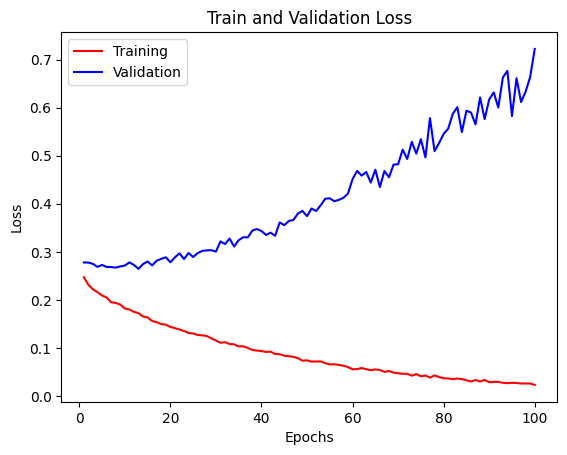

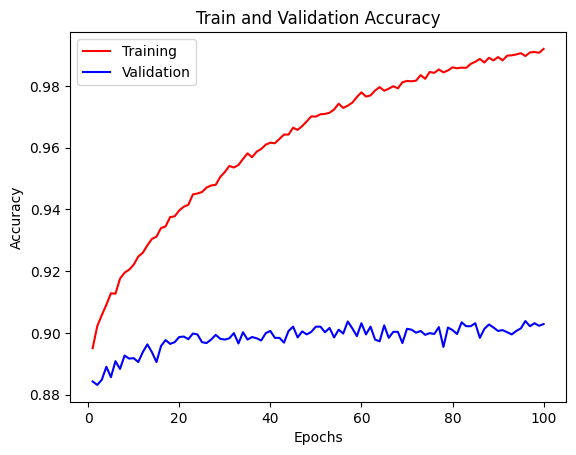

In [36]:
training_loop(100, train_loader, val_loader, optimizer, loss_function, model_load)

              precision    recall  f1-score   support

         0.0       0.88      0.93      0.90      3462
         1.0       0.93      0.88      0.91      3693

    accuracy                           0.90      7155
   macro avg       0.91      0.91      0.90      7155
weighted avg       0.91      0.90      0.90      7155



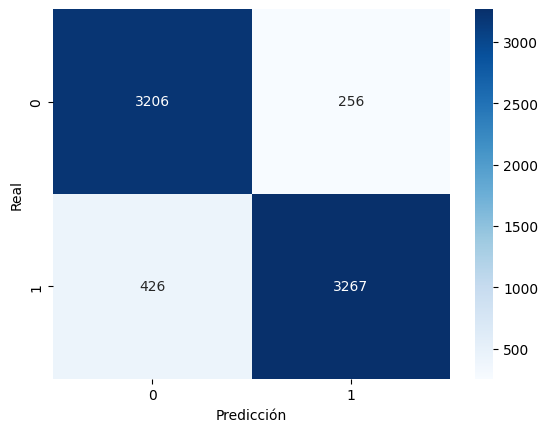

In [37]:
model_load = CustomModel(model_name)
evaluate_model(model_load, test_loader)